<hr/>

# EN.520.637 Foundations of Reinforcement Learning

<hr/>

<h1><font color="darkblue">Lab 6: Deep Q-learning  </font></h1>






Import torch, Gym and other necessary libraries

In [10]:
%pylab inline
import matplotlib.pyplot as plt

from torch import nn
import torch
import gym
from collections import deque
import itertools
import numpy as np
import random

env = gym.make('CartPole-v1')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [11]:
GAMMA = 0.99
BATCH_SIZE = 32
BUFFER_SIZE = 50000
MIN_REPLY_SIZE = 1000
EPSILON_START = 1.0
EPSILON_END = 0.02
EPSILON_DECAY = 10000
TARGET_UPDATE_FREQ = 1000

In [12]:
class Network(nn.Module):
    def __init__(self,env):
        super().__init__()

        in_features = int(np.prod(env.observation_space.shape))

        self.net = nn.Sequential(
            nn.Linear(in_features,64),
            nn.Tanh(),
            nn.Linear(64,env.action_space.n))

    def forward(self,x):
        return self.net(x)

    def act(self,obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32)
        q_values = self(obs_t.unsqueeze(0))

        max_q_index = torch.argmax(q_values, dim=1)[0]
        action = max_q_index.detach().item()

        return action

In [13]:
def deep_Q_learning(Network):
  replay_buffer = deque(maxlen=BUFFER_SIZE)
  rew_buffer = deque([0.0],maxlen=100)
  set_size = 10
  step_list = deque([0.0],maxlen=set_size)


  episode = 0


  episode_reward = 0.0
  episode_step = 0.0

  n_set = 40
  result = np.zeros(n_set)
  counter = 0

  online_net = Network(env)
  target_net = Network(env)



  target_net.load_state_dict(online_net.state_dict())

  optimizer = torch.optim.Adam(online_net.parameters(), lr=5e-4)

  #initiallize replay buffer
  obs = env.reset()
  if gym.__version__>'0.26.0':
      obs = obs[0]
  for _ in range(MIN_REPLY_SIZE):
      action = env.action_space.sample()

      #################### simulate one step
      if gym.__version__>'0.26.0':
          new_obs, rew, terminated, truncated, _ = env.step(action)
          done = terminated or truncated
      else:
          new_obs, rew, done, _ = env.step(action)
      ####################

      transition = (obs, action, rew, done, new_obs)
      replay_buffer.append(transition)
      obs = new_obs

      if done:
          obs = env.reset()
          if gym.__version__>'0.26.0':
              obs = obs[0]

  # Main Training Loop
  obs = env.reset()
  if gym.__version__>'0.26.0':
      obs = obs[0]


  for step in itertools.count():
      epsilon = np.interp(step, [0, EPSILON_DECAY], [EPSILON_START,EPSILON_END])

      rnd_sample = random.random()

      if rnd_sample <= epsilon:
          action = env.action_space.sample()
      else:
          action = online_net.act(obs)

      #################### simulate one step
      if gym.__version__>'0.26.0':
          new_obs, rew, terminated, truncated, _ = env.step(action)
          done = terminated or truncated
      else:
          new_obs, rew, done, _ = env.step(action)
      ####################
      transition = (obs, action, rew, done, new_obs)
      replay_buffer.append(transition)
      obs = new_obs

      episode_reward += rew
      episode_step += 1

      if done:
          episode += 1

          obs = env.reset()
          if gym.__version__>'0.26.0':
              obs = obs[0]
          step_list.append(episode_step)
          rew_buffer.append(episode_reward)
          episode_reward = 0.0
          episode_step = 0.0

      #Start Gradient Step
      transitions = random.sample(replay_buffer, BATCH_SIZE)

      obses = np.asarray([t[0] for t in transitions])
      actions = np.asarray([t[1] for t in transitions])
      rews = np.asarray([t[2] for t in transitions])
      dones = np.asarray([t[3] for t in transitions])
      new_obses = np.asarray([t[4] for t in transitions])

      obses_t = torch.as_tensor(obses, dtype=torch.float32)
      actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
      rews_t = torch.as_tensor(rews, dtype=torch.float32).unsqueeze(-1)
      dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
      new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)


      # Compute Targets
      target_q_values = target_net(new_obses_t)
      max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]

      targets = rews_t + GAMMA*(1 - dones_t)*max_target_q_values

      # Compute Loss
      q_values = online_net(obses_t)

      action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

      loss = nn.functional.smooth_l1_loss(action_q_values, targets)

      #Gradient Descent
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      # Update Target Network
      if step % TARGET_UPDATE_FREQ == 0:
          target_net.load_state_dict(online_net.state_dict())

      #Logging
      if episode % (set_size+1) == 0:
          episode += 1
          result[counter] = np.mean(step_list)
          print("Finishing set {}/{}...".format(counter+1,n_set),end="\r",flush=True)
          if counter == n_set-1:
              break
          counter+=1

  return result, set_size

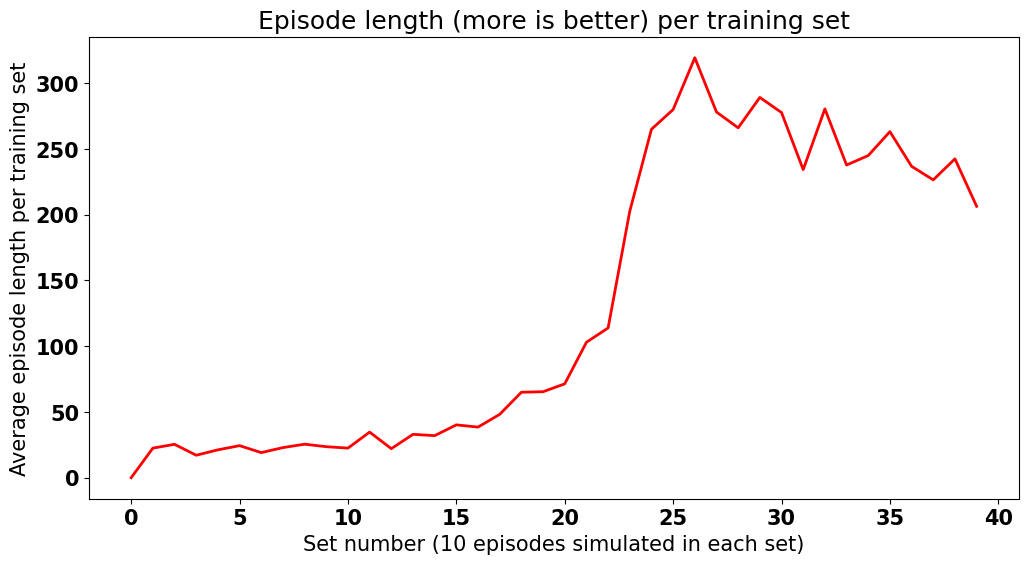

In [14]:
result, set_size = deep_Q_learning(Network)

font = {'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

figure(figsize=(12,6))
ax = subplot(1,1,1)
ax.plot(range(len(result)), result, linewidth=2, color='r')
plt.title("Episode length (more is better) per training set")
plt.ylabel("Average episode length per training set");
plt.xlabel("Set number ({} episodes simulated in each set)".format(set_size));

#### 0. Understand the Deep Q-learning codes above, a good referance can be found in Algorithm 1 [Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015)](https://www.nature.com/articles/nature14236) <br>

### [Task 1: 10 points]. Try to apply 2 different activation functions (e.g. Sigmoid, ReLU) in the  Deep Q-learning codes above. Then, plot the average episode length (same plot as above).

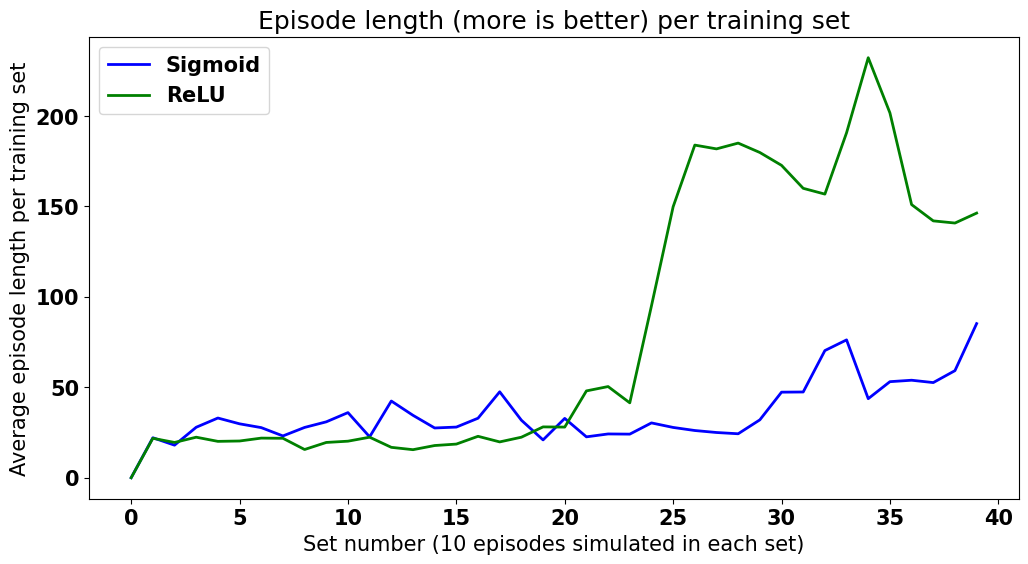

In [15]:
class Network_Sigmoid(nn.Module):
    def __init__(self,env):
        super().__init__()

        in_features = int(np.prod(env.observation_space.shape))

        self.net = nn.Sequential(
            nn.Linear(in_features,64),
            nn.Sigmoid(),
            nn.Linear(64,env.action_space.n))

    def forward(self,x):
        return self.net(x)

    def act(self,obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32)
        q_values = self(obs_t.unsqueeze(0))

        max_q_index = torch.argmax(q_values, dim=1)[0]
        action = max_q_index.detach().item()

        return action

class Network_ReLU(nn.Module):
    def __init__(self,env):
        super().__init__()

        in_features = int(np.prod(env.observation_space.shape))

        self.net = nn.Sequential(
            nn.Linear(in_features,64),
            nn.ReLU(),
            nn.Linear(64,env.action_space.n))

    def forward(self,x):
        return self.net(x)

    def act(self,obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32)
        q_values = self(obs_t.unsqueeze(0))

        max_q_index = torch.argmax(q_values, dim=1)[0]
        action = max_q_index.detach().item()

        return action

result_sigmoid, set_size = deep_Q_learning(Network_Sigmoid)
result_relu, set_size = deep_Q_learning(Network_ReLU)

font = {'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

figure(figsize=(12,6))
ax = subplot(1,1,1)
ax.plot(range(len(result_sigmoid)), result_sigmoid, linewidth=2, label = "Sigmoid", color='b')
ax.plot(range(len(result_relu)), result_relu, linewidth=2, label = "ReLU", color='g')
plt.title("Episode length (more is better) per training set")
plt.ylabel("Average episode length per training set");
plt.xlabel("Set number ({} episodes simulated in each set)".format(set_size));
plt.legend()

### [Task 2: 10 points]. Using the best activation function you found in (1), try to modify the network stucture defined in self.net to improve the average episode length. (e.g. add/decrease number of nodes/hidden layers) Plot the average episode length.

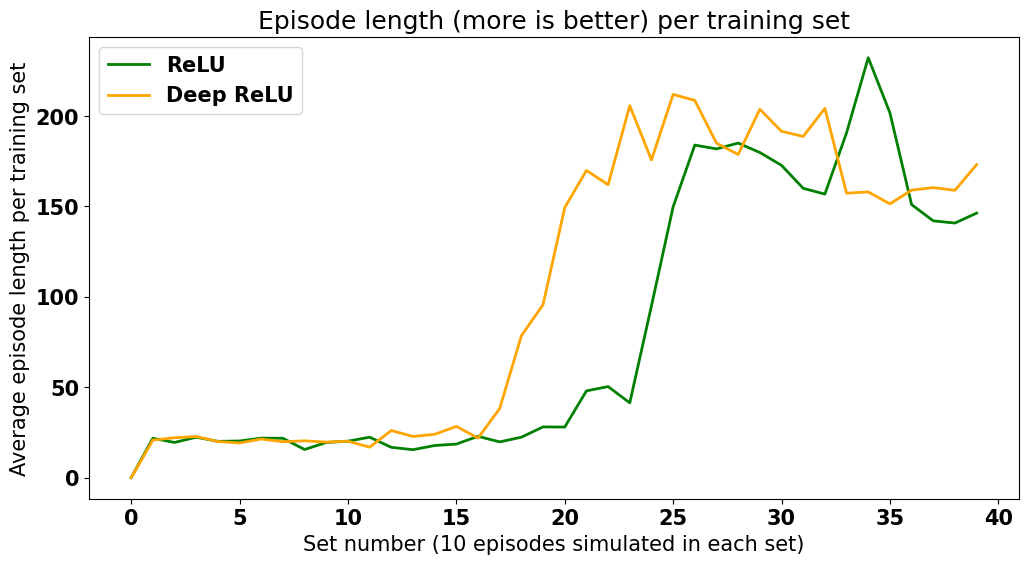

In [19]:
class Deep_Network_ReLU(nn.Module):
    def __init__(self,env):
        super().__init__()

        in_features = int(np.prod(env.observation_space.shape))

        self.net = nn.Sequential(
            nn.Linear(in_features,128),
            nn.ReLU(),
            nn.Linear(128,env.action_space.n))

    def forward(self,x):
        return self.net(x)

    def act(self,obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32)
        q_values = self(obs_t.unsqueeze(0))

        max_q_index = torch.argmax(q_values, dim=1)[0]
        action = max_q_index.detach().item()

        return action

result_drelu, set_size = deep_Q_learning(Deep_Network_ReLU)

font = {'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

figure(figsize=(12,6))
ax = subplot(1,1,1)
ax.plot(range(len(result_relu)), result_relu, linewidth=2, label = "ReLU", color='g')
ax.plot(range(len(result_drelu)), result_drelu, linewidth=2, label = "Deep ReLU", color='orange')
plt.title("Episode length (more is better) per training set")
plt.ylabel("Average episode length per training set");
plt.xlabel("Set number ({} episodes simulated in each set)".format(set_size));
plt.legend()

### [Task 3: 10 points].  With the network stucture and activation function unchanged, try to modify the reward to improve the average episode length. (e.g. give more reward if angle is small) Plot it.

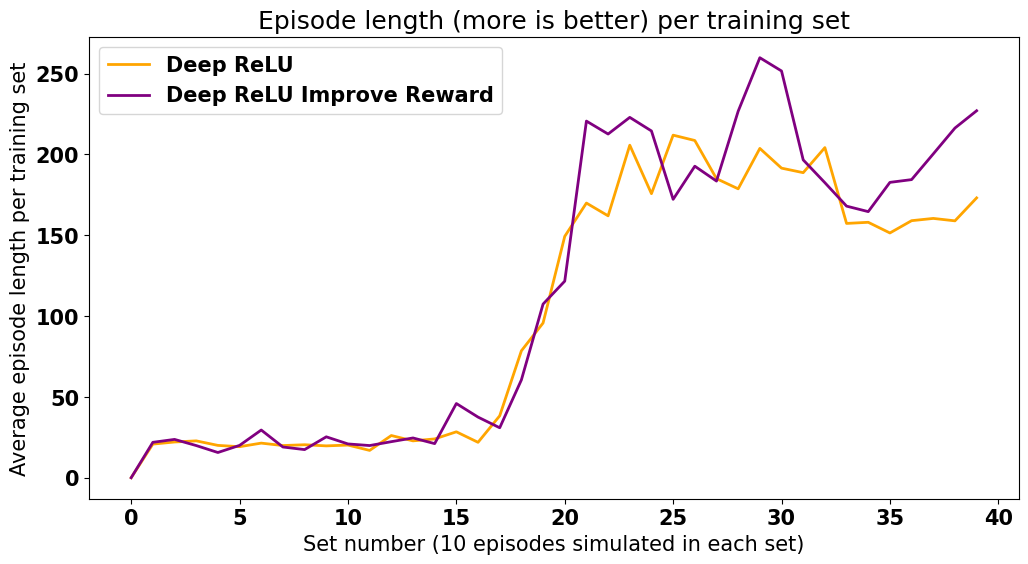

In [84]:
def deep_Q_learning_3(Network):
  replay_buffer = deque(maxlen=BUFFER_SIZE)
  rew_buffer = deque([0.0],maxlen=100)
  set_size = 10
  step_list = deque([0.0],maxlen=set_size)


  episode = 0


  episode_reward = 0.0
  episode_step = 0.0

  n_set = 40
  result = np.zeros(n_set)
  counter = 0

  online_net = Network(env)
  target_net = Network(env)



  target_net.load_state_dict(online_net.state_dict())

  optimizer = torch.optim.Adam(online_net.parameters(), lr=5e-4)

  #initiallize replay buffer
  obs = env.reset()
  if gym.__version__>'0.26.0':
      obs = obs[0]
  for _ in range(MIN_REPLY_SIZE):
      action = env.action_space.sample()

      #################### simulate one step
      if gym.__version__>'0.26.0':
          new_obs, rew, terminated, truncated, _ = env.step(action)
          done = terminated or truncated
      else:
          new_obs, rew, done, _ = env.step(action)
      ####################

      transition = (obs, action, rew, done, new_obs)
      replay_buffer.append(transition)
      obs = new_obs

      if done:
          obs = env.reset()
          if gym.__version__>'0.26.0':
              obs = obs[0]

  # Main Training Loop
  obs = env.reset()
  if gym.__version__>'0.26.0':
      obs = obs[0]


  for step in itertools.count():
      epsilon = np.interp(step, [0, EPSILON_DECAY], [EPSILON_START,EPSILON_END])

      rnd_sample = random.random()

      if rnd_sample <= epsilon:
          action = env.action_space.sample()
      else:
          action = online_net.act(obs)

      #################### simulate one step
      if gym.__version__>'0.26.0':
          new_obs, rew, terminated, truncated, _ = env.step(action)
          done = terminated or truncated
      else:
          new_obs, rew, done, _ = env.step(action)
      ####################
      transition = (obs, action, rew, done, new_obs)
      replay_buffer.append(transition)
      obs = new_obs

      episode_reward += rew
      episode_step += 1

      if done:
          episode += 1

          obs = env.reset()
          if gym.__version__>'0.26.0':
              obs = obs[0]
          step_list.append(episode_step)
          rew_buffer.append(episode_reward)
          episode_reward = 0.0
          episode_step = 0.0

      #Start Gradient Step
      transitions = random.sample(replay_buffer, BATCH_SIZE)

      obses = np.asarray([t[0] for t in transitions])
      actions = np.asarray([t[1] for t in transitions])
      rews = np.asarray([t[2] for t in transitions])
      dones = np.asarray([t[3] for t in transitions])
      new_obses = np.asarray([t[4] for t in transitions])

      #Modify reward by giving more reward if angle is small
      angle = np.copy(new_obses[:, 2])
      angle[angle > 0] = 0
      rews -= 0.5 * angle

      obses_t = torch.as_tensor(obses, dtype=torch.float32)
      actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
      rews_t = torch.as_tensor(rews, dtype=torch.float32).unsqueeze(-1)
      dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
      new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)

      # Compute Targets
      target_q_values = target_net(new_obses_t)
      max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]

      targets = rews_t + GAMMA*(1 - dones_t)*max_target_q_values

      # Compute Loss
      q_values = online_net(obses_t)

      action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

      loss = nn.functional.smooth_l1_loss(action_q_values, targets)

      #Gradient Descent
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      # Update Target Network
      if step % TARGET_UPDATE_FREQ == 0:
          target_net.load_state_dict(online_net.state_dict())

      #Logging
      if episode % (set_size+1) == 0:
          episode += 1
          result[counter] = np.mean(step_list)
          print("Finishing set {}/{}...".format(counter+1,n_set),end="\r",flush=True)
          if counter == n_set-1:
              break
          counter+=1

  return result, set_size

result_drelu_ir, set_size = deep_Q_learning_3(Deep_Network_ReLU)

font = {'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

figure(figsize=(12,6))
ax = subplot(1,1,1)
ax.plot(range(len(result_drelu)), result_drelu, linewidth=2, label = "Deep ReLU", color='orange')
ax.plot(range(len(result_drelu_ir)), result_drelu_ir, linewidth=2, label = "Deep ReLU Improve Reward", color='purple')
plt.title("Episode length (more is better) per training set")
plt.ylabel("Average episode length per training set");
plt.xlabel("Set number ({} episodes simulated in each set)".format(set_size));
plt.legend()